In [1]:
import pycewise
import random
import pandas
from plotnine import *
import numpy

print(pycewise.__version__)
print(pycewise.__git_version__)

0.1.1
00bcfcd8d9ad0c500bf79bdb54326f37c419a09a


First, let's generate some data. The model we use here has been computer for the memcpy dataset (see the [notebook](https://github.com/Ezibenroc/pycewise/blob/00bcfcd8d9ad0c500bf79bdb54326f37c419a09a/notebooks/regressions_comparison.ipynb), cell 6).

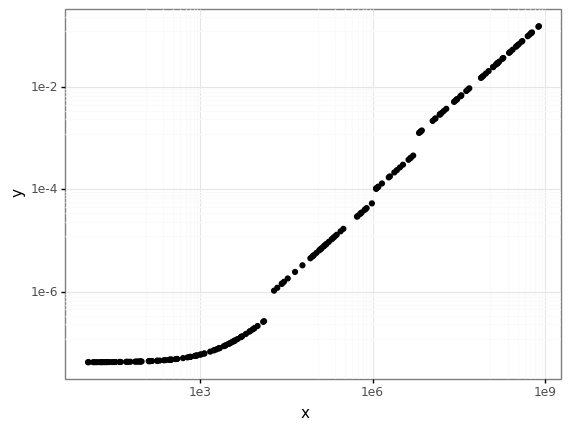

<ggplot: (8770980792219)>

In [2]:
def model(x):
    if x <= 1.450e+04:
        y = 1.739e-11*x + 4.181e-08
    elif x <= 9.925e+05:
        y = 5.457e-11*x
    elif x <= 5.630e+06:
        y = 8.929e-11*x
    else:
        y = 1.935e-10*x + 1.294e-05
    return y

N = 200
numpy.random.seed(42)
x = 10**numpy.random.uniform(1, 9, N)
y = numpy.array(list(map(model, x)))
df = pandas.DataFrame({'x': x, 'y': y})
(ggplot(df)
    + aes(x='x', y='y')
    + geom_point()
    + scale_x_log10()
    + scale_y_log10()
    + theme_bw()
)

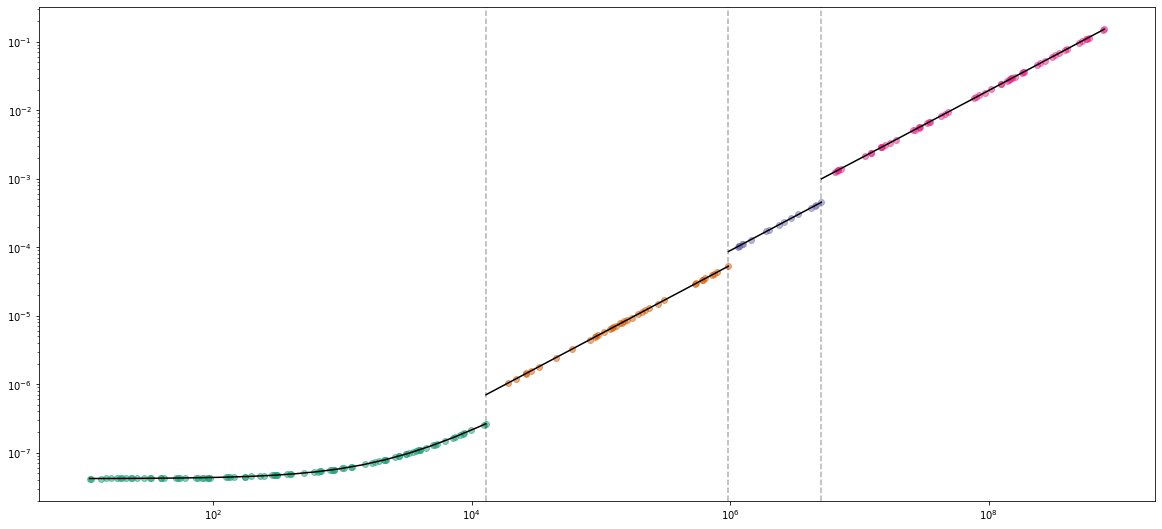

In [3]:
reg = pycewise.compute_regression(df['x'], df['y'], mode='log').auto_simplify()
reg.plot_dataset(log=True)

In [4]:
reg

-inf < x ≤ 1.287e+04
	y ~ 1.739e-11x + 4.181e-08
1.287e+04 < x ≤ 9.691e+05
	y ~ 5.457e-11x + 3.388e-21
9.691e+05 < x ≤ 5.081e+06
	y ~ 8.929e-11x + 5.421e-20
5.081e+06 < x ≤ inf
	y ~ 1.935e-10x + 1.294e-05

In [5]:
def compute_df_pred(df_data, mode):
    reg = pycewise.compute_regression(df_data['x'], df_data['y'], mode=mode).auto_simplify()
    numpy.random.seed(42)
    df = pandas.DataFrame({'x':10**numpy.random.uniform(1, 9, 1000), 'mode':mode})
    df['y'] = df.apply(lambda row: reg.predict(row['x']), axis=1)
    df['segment'] = 0
    for i, bp in enumerate(reg.breakpoints):
        df.loc[df['x'] > bp, 'segment'] = i+1
    return df

df['noise'] = 'no noise'
pred_nonoise = pandas.concat([compute_df_pred(df, mode) for mode in ['BIC', 'weighted', 'log']])
pred_nonoise['noise'] = 'no noise'

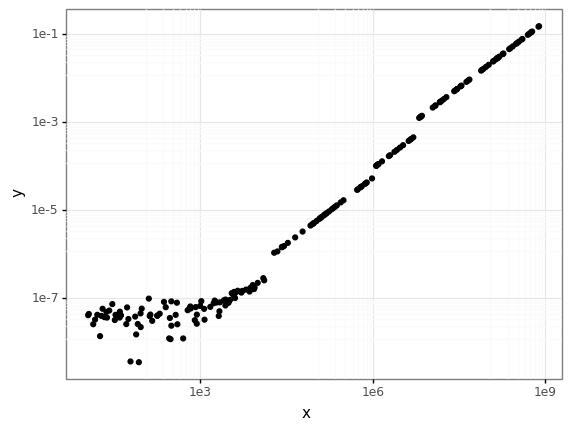

<ggplot: (8770967259789)>


In [6]:
df_homoscedastic = df.copy()
df_homoscedastic['noise'] = 'homoscedastic'
numpy.random.seed(42)
df_homoscedastic['y'] += numpy.random.normal(0, 2e-8, len(df))
print(ggplot(df_homoscedastic)
    + aes(x='x', y='y')
    + geom_point()
    + scale_x_log10()
    + scale_y_log10()
    + theme_bw()
)
pred_homoscedastic = pandas.concat([compute_df_pred(df_homoscedastic, mode) for mode in ['BIC', 'weighted', 'log']])
pred_homoscedastic['noise'] = 'homoscedastic'

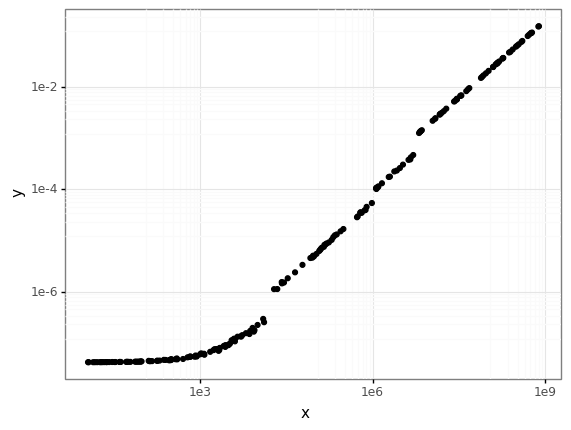

<ggplot: (-9223363265887690131)>


In [7]:
df_heteroscedastic = df.copy()
df_heteroscedastic['noise'] = 'heteroscedastic'
numpy.random.seed(42)
df_heteroscedastic['y'] += numpy.random.normal(0, 2e-12, len(df)) * df['x']
print(ggplot(df_heteroscedastic)
    + aes(x='x', y='y')
    + geom_point()
    + scale_x_log10()
    + scale_y_log10()
    + theme_bw()
)
pred_heteroscedastic = pandas.concat([compute_df_pred(df_heteroscedastic, mode) for mode in ['BIC', 'weighted', 'log']])
pred_heteroscedastic['noise'] = 'heteroscedastic'

In [8]:
data = pandas.concat([df, df_homoscedastic, df_heteroscedastic])
predictions = pandas.concat([pred_nonoise, pred_homoscedastic, pred_heteroscedastic])

In [9]:
%load_ext rpy2.ipython

In [13]:
%%R -i data -w 5 -h 5 --units in -r 200

library(dplyr)
library(ggplot2)

str(data)

'data.frame':	600 obs. of  3 variables:
 $ x    : num  9.92e+03 4.03e+08 7.18e+06 6.16e+05 1.77e+02 ...
 $ y    : num  2.14e-07 7.81e-02 1.40e-03 3.36e-05 4.49e-08 ...
 $ noise: chr  "no noise" "no noise" "no noise" "no noise" ...


In [14]:
%%R -i predictions -w 5 -h 5 --units in -r 200

str(predictions)

'data.frame':	9000 obs. of  5 variables:
 $ x      : num  9.92e+03 4.03e+08 7.18e+06 6.16e+05 1.77e+02 ...
 $ mode   : chr  "BIC" "BIC" "BIC" "BIC" ...
 $ y      : num  2.14e-07 7.81e-02 1.40e-03 3.36e-05 4.49e-08 ...
 $ segment: int  0 3 3 1 0 0 0 3 1 2 ...
 $ noise  : chr  "no noise" "no noise" "no noise" "no noise" ...


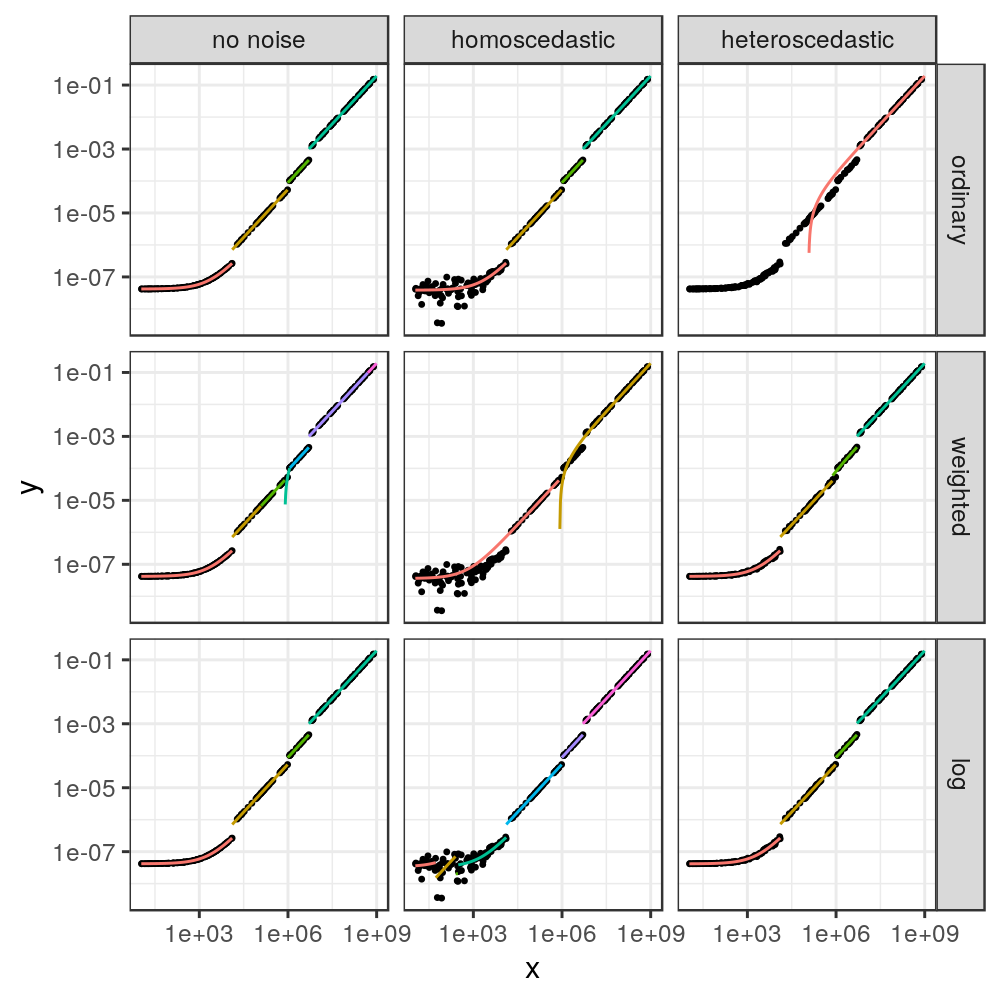

In [15]:
%%R -w 5 -h 5 --units in -r 200

predictions = predictions %>%
    mutate(mode=ifelse(mode=="BIC", "ordinary", mode)) %>%
    mutate(mode=factor(mode, levels=c("ordinary", "weighted", "log")))
predictions = predictions %>%
    mutate(noise=factor(noise, levels=c("no noise", "homoscedastic", "heteroscedastic")))
data = data %>%
    mutate(noise=factor(noise, levels=c("no noise", "homoscedastic", "heteroscedastic")))

ggplot() +
    aes(x=x, y=y) +
    geom_point(data=data, size=0.5) +
    geom_line(data=predictions %>% arrange(x), aes(color=factor(segment))) +
    facet_grid(mode~noise) +
    scale_x_log10() +
    scale_y_log10() +
    theme_bw() +
    theme(legend.position='none')

## TODO

- Also use the real dataset, with this one only the log-regression performs well.
- Try datadog and cubist.